# Data Challenge ENS "Reconstruction of Liquid Asset Performance"

**Groupe : Elyas Benyamina, Alexis Ibrahim & Antoine Mathis**

**Professeur : Bertrand Michel**

Sommaire :
    
1. Import des librairies
2. Lecture des données
3. Manipulation des données
4. Analyse des données
5. Gestion des valeurs manquantes en effectuant un traitement par ligne
6. Algorithmes de prédiction
7. Résultats
8. Annexe : Autres approches et pistes

## 1. Import des librairies

In [85]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn import linear_model
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import uniform, truncnorm, randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.cluster import KMeans
from sklearn.gaussian_process.kernels import RBF
import seaborn as sns

## 2. Lecture des données

### Téléchargement des données depuis un compte Google Drive connecté (pour les utilisateurs de Google Colab)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r "/content/drive/MyDrive/Colab Notebooks/y_train.csv" "/content/"
!cp -r "/content/drive/My Drive/Colab Notebooks/X_test.csv" "/content/"
!cp -r "/content/drive/My Drive/Colab Notebooks/X_train.csv" "/content/"
!cp -r "/content/drive/My Drive/Colab Notebooks/supplementary_data.csv" "/content/"

### Téléchargement des données via URL

In [87]:
import gdown

url = 'https://drive.google.com/uc?id=1WoeLMFKMhJUfvRFgeD0SHwCigBHGCbal'
output = 'X_train.csv'
gdown.download(url, output, quiet=False)

url = 'https://drive.google.com/uc?id=1gZpX7VL1-Cw2TmtBKOWFCpNBK45UmcPM'
output = 'X_test.csv'
gdown.download(url, output, quiet=False)


url = 'https://drive.google.com/uc?id=1kdgBQ-xebQX7B-6MdXtJPrrpN6mgE0n-'
output = 'y_train.csv'
gdown.download(url, output, quiet=False)

url = 'https://drive.google.com/uc?id=1Fg31pCfHZSehhLEBP3xtgV6y6zKrSuQh'
output = 'supplementary_data.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1WoeLMFKMhJUfvRFgeD0SHwCigBHGCbal
To: /home/jupyter/X_train.csv
100%|██████████| 557M/557M [00:02<00:00, 244MB/s]  
Downloading...
From: https://drive.google.com/uc?id=1gZpX7VL1-Cw2TmtBKOWFCpNBK45UmcPM
To: /home/jupyter/X_test.csv
100%|██████████| 239M/239M [00:01<00:00, 194MB/s]  
Downloading...
From: https://drive.google.com/uc?id=1kdgBQ-xebQX7B-6MdXtJPrrpN6mgE0n-
To: /home/jupyter/y_train.csv
100%|██████████| 7.76M/7.76M [00:00<00:00, 71.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Fg31pCfHZSehhLEBP3xtgV6y6zKrSuQh
To: /home/jupyter/supplementary_data.csv
100%|██████████| 3.24k/3.24k [00:00<00:00, 7.12MB/s]


'supplementary_data.csv'

### Lecture des données


In [88]:
X_train = pd.read_csv('X_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
X_test = pd.read_csv('X_test.csv', index_col=0)
supp_data = pd.read_csv('supplementary_data.csv')

## 3. Manipulation des données

### Fusion des données jounrnalières (obtention d'un tableau une ligne = un jour)

In [ ]:
def daily_returns(X_train, y_train):
    idx_ret_features = np.where(X_train.columns.str.contains('RET'))[0]
    i_returns = {}
    l_returns ={}
    for day in tqdm(X_train.ID_DAY.unique()):
        u = X_train.loc[X_train.ID_DAY == day]
        a = u.iloc[0, idx_ret_features]
        b = y_train[X_train.ID_DAY == day]['RET_TARGET']
        b.index = ['RET_' + str(ret_target) for ret_target in u.ID_TARGET]
        i_returns[day] = a
        l_returns[day] = b
    i_returns = pd.DataFrame(i_returns).T.astype(float)
    l_returns = pd.DataFrame(l_returns).T.astype(float)
    
    
    return i_returns, l_returns

In [ ]:
i_returns,l_returns=daily_returns(X_train,y_train)
i_returns.head()

  0%|          | 0/2748 [00:00<?, ?it/s]

,RET_216,RET_238,RET_45,RET_295,RET_230,RET_120,RET_188,RET_260,RET_15,RET_150,...,RET_108,RET_122,RET_194,RET_72,RET_293,RET_281,RET_193,RET_95,RET_162,RET_297
3316,0.004024,0.009237,0.004967,NaN,0.017040,0.013885,0.041885,0.015207,-0.003143,0.018565,...,0.027374,0.007596,0.015010,0.014733,-0.000476,0.006539,-0.010233,0.001251,-0.003102,-0.094847
3355,0.025848,-0.002109,-0.021802,0.040229,0.015093,-0.015498,0.011188,0.011622,0.016624,0.041997,...,-0.007413,0.001506,0.003077,-0.002341,0.061228,0.005301,0.008942,-0.010232,0.005529,0.006545
1662,-0.012267,0.007461,0.051311,0.105340,-0.006361,0.004964,0.011933,0.018921,-0.035044,0.044667,...,0.005593,0.009226,0.032670,-0.000716,0.008429,-0.002871,0.009932,0.023721,0.009349,0.033554
3405,-0.033598,-0.003446,-0.009100,0.016753,-0.016952,-0.008924,-0.010984,0.001948,-0.034591,-0.029038,...,0.002788,0.001551,-0.008077,0.009507,-0.008005,-0.016593,-0.007481,-0.024835,0.004360,0.031087
1602,0.029170,-0.084293,0.000325,0.021458,-0.018345,-0.012230,-0.001818,0.000842,0.003885,0.007138,...,-0.031061,-0.012181,0.002507,0.004408,-0.022913,-0.010133,-0.006468,-0.025205,-0.001612,-0.056735


### Utilisation des données supplémentaires

In [90]:
assets_coefs = {}
for idx, row in tqdm(supp_data.iterrows()):
    if row.iloc[1:].sum() == 0:
        assets_coefs['RET_'+ str(row.ID_asset)] = np.zeros(4, dtype = float)
    else:  
        lst_classes = (row.iloc[1:]).to_numpy()/(row.iloc[1:].sum())
        assets_coefs['RET_'+ str(row.ID_asset)] = lst_classes
assets_coefs = pd.DataFrame(assets_coefs).astype(float)
assets_coefs

0it [00:00, ?it/s]

,RET_216,RET_238,RET_45,RET_295,RET_230,RET_120,RET_188,RET_260,RET_15,RET_150,...,RET_19,RET_28,RET_251,RET_278,RET_76,RET_241,RET_214,RET_102,RET_145,RET_155
0,0.055556,0.054054,0.050000,0.063291,0.044944,0.040816,0.063291,0.055556,0.064103,0.055944,...,0.058824,0.083333,0.037037,0.047619,0.052632,0.037975,0.051282,0.052632,0.055556,0.08
1,0.055556,0.054054,0.083333,0.139241,0.112360,0.081633,0.139241,0.055556,0.141026,0.139860,...,0.058824,0.083333,0.074074,0.095238,0.052632,0.101266,0.051282,0.052632,0.055556,0.08
2,0.333333,0.324324,0.333333,0.310127,0.314607,0.346939,0.310127,0.333333,0.314103,0.314685,...,0.294118,0.250000,0.333333,0.333333,0.263158,0.329114,0.333333,0.263158,0.333333,0.28
3,0.555556,0.567568,0.533333,0.487342,0.528090,0.530612,0.487342,0.555556,0.480769,0.489510,...,0.588235,0.583333,0.555556,0.523810,0.631579,0.531646,0.564103,0.631579,0.555556,0.56


## 4. Analyse des données 

### Densité des valeurs d'un actif

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='RET_130', ylabel='Density'>

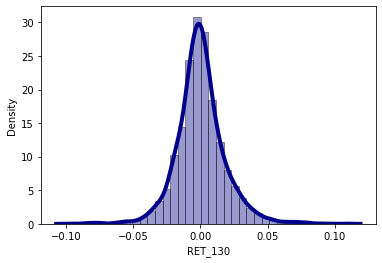

In [91]:
sns.distplot(l_returns['RET_130'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

### Matrice de correlation

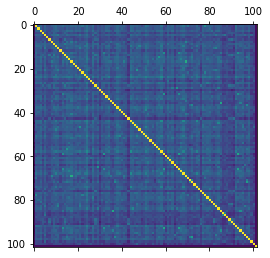

In [92]:
corr_df = X_train.corr()
#print(corr_df, "\n")
corr_df = X_train.corr(method='pearson')
plt.matshow(corr_df)
plt.show()

### Valeurs manquantes par actif

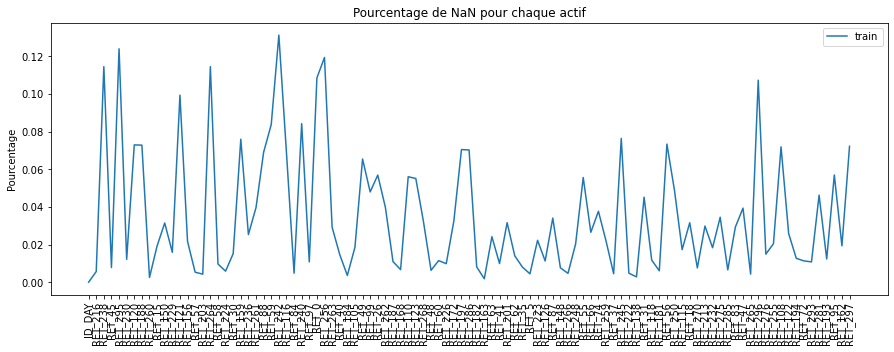

In [93]:
plt.figure(figsize=(15, 5))
X_train_modified=X_train.drop('ID_DAY',axis=1)
X_train_modified=X_train.drop('ID_TARGET',axis=1)
(X_train_modified.isna().sum() / len(X_train_modified)).plot(label='train', use_index=False)
#(X_test.isna().sum() / len(X_test)).plot(label='test', use_index=False)
plt.xticks(np.arange(101), X_train_modified.columns, rotation=90)
plt.ylabel('Pourcentage')
plt.title("Pourcentage de NaN pour chaque actif")
plt.legend()
plt.show()

Exemple de selection de features : cas d'un Random Forest Classifier


### Importance des features pour un RandomForestClassifier


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


<AxesSubplot:>

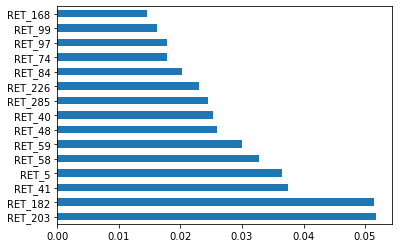

In [94]:
model = RandomForestClassifier()
X_model = pd.read_csv("X_train.csv",index_col=0)

Y_model = pd.read_csv("y_train.csv",index_col=0)

X_model.fillna(0,inplace=True)

X_model.drop('ID_TARGET',inplace=True,axis=1)

Y_model.fillna(0,inplace=True)

Y_model['RET_TARGET_CLASS'] = np.where(Y_model['RET_TARGET']>0, 1, -1)
Y_model.drop('RET_TARGET',axis=1,inplace=True)
model.fit(X_model, Y_model)


(pd.Series(model.feature_importances_, index=X_model.columns)
   .nlargest(15)
   .plot(kind='barh')) 

## 5. Gestion des valeurs manquantes en effectuant un traitement par ligne

### Fonction remplaçant les valeurs manquantes en moyennant par rapport au catégorie d'actifs relativement aux valeurs journalières

In [95]:
def prepro(df):
    imputed_df = df.copy()
    for idx, row in tqdm(df.iterrows()):
        non_na_pos = np.where(pd.notna(row))[0]
        non_na_names = df.columns[non_na_pos]
        N = np.array([(assets_coefs[non_na_names].iloc[i, :]).sum() for i in range(4)])
        values = row[non_na_pos].to_numpy()
        W = np.array([(assets_coefs[non_na_names].iloc[i, :].to_numpy() * values).sum() for i in range(4)])/N
        for j in range(len(row)):
            if pd.isna(row[j]):
                asset_name = df.columns[j]
                p = np.array(assets_coefs[asset_name])
                V = (W*p).sum()
                imputed_df.loc[idx, asset_name] = V
    return imputed_df

### Fonction preprocess supprimant les lignes où il existe des valeurs d'actifs manquants

In [96]:
def prepro_supp(df):
    #imputed_df['suppr']=0
    #imputed_df=imputed_df.loc[:, 'suppr'] = 0
    imputed_df = df.copy()
    imputed_df.insert(0, 'suppr', 0)
    for idx, row in tqdm(imputed_df.iterrows()):
        na_pos = np.where(pd.isna(row))[0]
        if len(na_pos)==0:
         imputed_df.loc[idx,'suppr']=1        
    return imputed_df   

## 6. Algorithmes de prédiction

### Lasso

In [102]:
def lasso(X_train, y_train, X_to_predict, alpha, n_clusters, preprocess_mode):
    i_returns, l_returns = daily_returns(X_train, y_train)
    prediction=pd.DataFrame()
    listecolonnes=[]
    if preprocess_mode == 'avg_column':
        
        my_imputer_i = SimpleImputer()
        illiquid_returns = pd.DataFrame(my_imputer_i.fit_transform(i_returns))
        illiquid_returns.columns = i_returns.columns
        
        my_imputer_l = SimpleImputer()
        liquid_returns = pd.DataFrame(my_imputer_l.fit_transform(l_returns))
        liquid_returns.columns = l_returns.columns
        
        kmeans = KMeans(n_clusters=n_clusters, n_init=1, init='k-means++').fit(liquid_returns.T)
        groupes = kmeans.predict(liquid_returns.T)
        #print(groupes)
        
    elif preprocess_mode == 'avg_line':
        
        illiquid_returns = prepro(i_returns)
        liquid_returns = prepro(l_returns)
        
        kmeans = KMeans(n_clusters=n_clusters, n_init=1, init='k-means++').fit(liquid_returns.T)
        groupes = kmeans.predict(liquid_returns.T)
        
        
    for i in range(n_clusters):
        y_test_g=liquid_returns.iloc[:,np.where(groupes==i)[0]]
        model=linear_model.Lasso(alpha)
        #lasso = Lasso(random_state=0, max_iter=10000)
        model.fit(illiquid_returns, y_test_g)
        idx_ret_features = np.where(X_to_predict.columns.str.contains('RET'))[0]
        returns_to_predict = {}
        for day in tqdm(X_to_predict.ID_DAY.unique()):
            u = X_to_predict.loc[X_to_predict.ID_DAY == day]
            a = u.iloc[0, idx_ret_features]
            returns_to_predict[day] = a
        returns_to_predict = pd.DataFrame(returns_to_predict).T.astype(float)

        if preprocess_mode == 'avg_column':
            my_imputer = SimpleImputer()
            imputed_returns_to_predict = pd.DataFrame(my_imputer.fit_transform(returns_to_predict))
            imputed_returns_to_predict.columns = returns_to_predict.columns

        elif preprocess_mode == 'avg_line':
            imputed_returns_to_predict = prepro(returns_to_predict)
            
        elif preprocess_mode == 'supp_line':
            imputed_returns_to_predict = prepro(returns_to_predict)
            
        prediction_n=pd.DataFrame(model.predict(imputed_returns_to_predict))
        prediction_n.columns=y_test_g.columns
        listecolonnes=listecolonnes+y_test_g.columns.values.tolist()
        prediction = pd.concat([prediction,prediction_n],axis=1)
    
    returns_predicted = {}
    day_list = []
    k = 0
    for day in tqdm(X_to_predict.ID_DAY.unique()):
        c=pd.Series(prediction.iloc[k,:])
        c.index = listecolonnes
        returns_predicted[day] = c
        day_list.append(day)
        k+=1
        
    returns_predicted = pd.DataFrame(returns_predicted).T.astype(float)
    
    y_pred = {}   
    for idx, row in tqdm(X_to_predict.iterrows()):
        day = int(row.ID_DAY)
        num_day = day_list.index(day)
        num_ret = int(row.ID_TARGET)
        str_ret = 'RET_' + str(num_ret)
        y_pred[idx] = (returns_predicted[str_ret].iloc[num_day])
        
    y_pred = pd.Series(y_pred, name="RET_TARGET")
    
    return np.sign(y_pred)

### Random Forest avec Randomized Grid Search

In [103]:
# Paramètres de la grille

random_grid = {
    'n_estimators': randint(4,200),
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    'min_samples_split': uniform(0.01, 0.199)
}

In [104]:
def rfgridsearch(X_train, y_train, X_to_predict, n_clusters, preprocess_mode):
    i_returns, l_returns = daily_returns(X_train, y_train)
    prediction=pd.DataFrame()
    listecolonnes=[]
    if preprocess_mode == 'avg_column':
        
        my_imputer_i = SimpleImputer()
        illiquid_returns = pd.DataFrame(my_imputer_i.fit_transform(i_returns))
        illiquid_returns.columns = i_returns.columns
        
        my_imputer_l = SimpleImputer()
        liquid_returns = pd.DataFrame(my_imputer_l.fit_transform(l_returns))
        liquid_returns.columns = l_returns.columns
        
        kmeans = KMeans(n_clusters=n_clusters, n_init=1, init='k-means++').fit(liquid_returns.T)
        groupes = kmeans.predict(liquid_returns.T)

    elif preprocess_mode == 'avg_line':
        
        illiquid_returns = prepro(i_returns)
        liquid_returns = prepro(l_returns)
        #illiquid_returns['suppr']=liquid_returns['suppr']
        #illiquid_returns=illiquid_returns[illiquid_returns['suppr']==0]
        #liquid_returns=liquid_returns[liquid_returns['suppr']==0]
        #liquid_returns=liquid_returns.drop(['suppr'],axis=1)
        #illiquid_returns=illiquid_returns.drop(['suppr'],axis=1)
        #liquid_returns=(liquid_returns-liquid_returns.mean())/(liquid_returns.std())
        #illiquid_returns=(illiquid_returns-illiquid_returns.mean())/(illiquid_returns.std())
        kmeans = KMeans(n_clusters=n_clusters, n_init=1, init='k-means++').fit(liquid_returns.T)
        groupes = kmeans.predict(liquid_returns.T)
        
    for i in range(n_clusters):
        y_test_g=liquid_returns.iloc[:,np.where(groupes==i)[0]]
        rf = RandomForestRegressor()
        n_folds = 3
        #model = GridSearchCV(rf, random_grid, cv=n_folds, n_iter=2, refit=False)
        model = RandomizedSearchCV(rf, random_grid, cv=n_folds, n_iter=50)
        model.fit(illiquid_returns, y_test_g)
        print(model.best_params_)
        
        idx_ret_features = np.where(X_to_predict.columns.str.contains('RET'))[0]
        returns_to_predict = {}
        for day in tqdm(X_to_predict.ID_DAY.unique()):
            u = X_to_predict.loc[X_to_predict.ID_DAY == day]
            a = u.iloc[0, idx_ret_features]
            returns_to_predict[day] = a
        returns_to_predict = pd.DataFrame(returns_to_predict).T.astype(float)

        if preprocess_mode == 'avg_column':
            my_imputer = SimpleImputer()
            imputed_returns_to_predict = pd.DataFrame(my_imputer.fit_transform(returns_to_predict))
            imputed_returns_to_predict.columns = returns_to_predict.columns

        elif preprocess_mode == 'avg_line':
            imputed_returns_to_predict = prepro(returns_to_predict)
        prediction_n=pd.DataFrame(model.predict(imputed_returns_to_predict))
        prediction_n.columns=y_test_g.columns
        listecolonnes=listecolonnes+y_test_g.columns.values.tolist()
        prediction = pd.concat([prediction,prediction_n],axis=1)
    
    returns_predicted = {}
    day_list = []
    k = 0
    for day in tqdm(X_to_predict.ID_DAY.unique()):
        c=pd.Series(prediction.iloc[k,:])
        c.index = listecolonnes
        returns_predicted[day] = c
        day_list.append(day)
        k+=1
        
    returns_predicted = pd.DataFrame(returns_predicted).T.astype(float)
    
    y_pred = {}   
    for idx, row in tqdm(X_to_predict.iterrows()):
        day = int(row.ID_DAY)
        num_day = day_list.index(day)
        num_ret = int(row.ID_TARGET)
        str_ret = 'RET_' + str(num_ret)
        y_pred[idx] = (returns_predicted[str_ret].iloc[num_day])
        
    y_pred = pd.Series(y_pred, name="RET_TARGET")
    
    return np.sign(y_pred)

### Régresion de processus gaussien

In [105]:
def gauss(X_train, y_train, X_to_predict, n_clusters, preprocess_mode):
    i_returns, l_returns = daily_returns(X_train, y_train)
    prediction=pd.DataFrame()
    listecolonnes=[]
    if preprocess_mode == 'avg_column':
        
        my_imputer_i = SimpleImputer()
        illiquid_returns = pd.DataFrame(my_imputer_i.fit_transform(i_returns))
        illiquid_returns.columns = i_returns.columns
        
        my_imputer_l = SimpleImputer()
        liquid_returns = pd.DataFrame(my_imputer_l.fit_transform(l_returns))
        liquid_returns.columns = l_returns.columns
        
        kmeans = KMeans(n_clusters=n_clusters, n_init=1, init='k-means++').fit(liquid_returns.T)
        groupes = kmeans.predict(liquid_returns.T)
        
    elif preprocess_mode == 'avg_line':
        
        illiquid_returns = prepro(i_returns)
        liquid_returns = prepro(l_returns)
        kmeans = KMeans(n_clusters=n_clusters, n_init=1, init='k-means++').fit(liquid_returns.T)
        groupes = kmeans.predict(liquid_returns.T)
        
    for i in range(n_clusters):
        y_test_g=liquid_returns.iloc[:,np.where(groupes==i)[0]]

        #kernel = DotProduct() + WhiteKernel()
        kernel=1.0 * RBF(1.0)
        model=GaussianProcessRegressor(kernel=kernel, random_state=0).fit(illiquid_returns, y_test_g)

        idx_ret_features = np.where(X_to_predict.columns.str.contains('RET'))[0]
        returns_to_predict = {}
        for day in tqdm(X_to_predict.ID_DAY.unique()):
            u = X_to_predict.loc[X_to_predict.ID_DAY == day]
            a = u.iloc[0, idx_ret_features]
            returns_to_predict[day] = a
        returns_to_predict = pd.DataFrame(returns_to_predict).T.astype(float)

        if preprocess_mode == 'avg_column':
            my_imputer = SimpleImputer()
            imputed_returns_to_predict = pd.DataFrame(my_imputer.fit_transform(returns_to_predict))
            imputed_returns_to_predict.columns = returns_to_predict.columns

        elif preprocess_mode == 'avg_line':
            imputed_returns_to_predict = prepro(returns_to_predict)
        prediction_n=pd.DataFrame(model.predict(imputed_returns_to_predict))
        prediction_n.columns=y_test_g.columns
        listecolonnes=listecolonnes+y_test_g.columns.values.tolist()
        prediction = pd.concat([prediction,prediction_n],axis=1)
    
    returns_predicted = {}
    day_list = []
    k = 0
    for day in tqdm(X_to_predict.ID_DAY.unique()):
        c=pd.Series(prediction.iloc[k,:])
        c.index = listecolonnes
        returns_predicted[day] = c
        day_list.append(day)
        k+=1
        
    returns_predicted = pd.DataFrame(returns_predicted).T.astype(float)
    
    y_pred = {}   
    for idx, row in tqdm(X_to_predict.iterrows()):
        day = int(row.ID_DAY)
        num_day = day_list.index(day)
        num_ret = int(row.ID_TARGET)
        str_ret = 'RET_' + str(num_ret)
        y_pred[idx] = (returns_predicted[str_ret].iloc[num_day])
        
    y_pred = pd.Series(y_pred, name="RET_TARGET")
    
    return np.sign(y_pred)

## 7. Résultats

### Création de lots d'apprentissage et de test

In [106]:
index_train, index_test = train_test_split(i_returns.index.values.tolist(), test_size=0.9, random_state=42)
index_train,index_nontraite=train_test_split(index_train, test_size=0.9, random_state=42)

X_t, y_t = X_train[X_train['ID_DAY'].isin(index_train)], y_train[X_train['ID_DAY'].isin(index_train)]
X_val, y_val = X_train[X_train['ID_DAY'].isin(index_test)], y_train[X_train['ID_DAY'].isin(index_test)]

### Fonction score

In [107]:
def weighted_accuracy(y_test, y_pred):
    y_abs = np.abs(y_test)
    norm = y_abs.sum()
    score = ((np.sign(y_pred) == np.sign(y_test)) * y_abs).sum() / norm
    return score

### Lancement de l'algorithme

In [ ]:
# Tests

pred = lasso(X_t, y_t, X_val, 2e-5, 3, 'avg_line')
weighted_accuracy(np.array(y_val.RET_TARGET), np.sign(pred))

  0%|          | 0/2474 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/2474 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0.6092058745704502

In [ ]:
# Résultat final

pred = lasso(X_train, y_train, X_test, 2e-5, 3, 'avg_line')

  0%|          | 0/2748 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1177 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Enregistrement des résultats

In [110]:
pred.name = "RET_TARGET"
pred = pred.astype(int)
pred.to_csv('y_res.csv', header=['RET_TARGET'])

## 8. Annexe : Autres approches et pistes

### ADA Boost Classification 
On utilise ici l'algorithme ADA Boost pour réaliser notre classification. 

Score obtenu : 0.6778301478142654


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler

#Création du classifieur avec méthode ADA BOOST
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)

#Lecture des données et applications des nouveaux traitements
X_train = pd.read_csv("X_train.csv",index_col=0)
Y_train=pd.read_csv("y_train.csv",index_col=0)
X_test = pd.read_csv("X_test.csv",index_col=0)

X_train.drop('ID_DAY',axis=1,inplace=True)
X_train.drop('ID_TARGET',axis=1,inplace=True)
X_test.drop('ID_DAY',axis=1,inplace=True)
X_test.drop('ID_TARGET',axis=1,inplace=True)


#Première approche : remplacement naif des valeurs manquantes par des zéros. 
X_train.fillna(0,inplace=True)
Y_train.fillna(0,inplace=True)
X_test.fillna(0,inplace=True)

#Normalisation et standardisation des données 
scaler=StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Transformation du problème en un problème de classification != regressiion

Y_train['RET_TARGET_CLASS'] = np.where(Y_train['RET_TARGET']>0, 1, -1)
Y_train.drop('RET_TARGET',axis=1,inplace=True)


# Train Adaboost Classifer
model = abc.fit(X_train_scaled, Y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test_scaled)

#Prédiction et écriture du fichier csv dans le chemin 
list_of_index=X_test.index


df = pd.DataFrame(data=y_pred, columns=['RET_TARGET'],index=list_of_index)

#Chemin vers lequel on veut enregistrer notre fichier submission csv
path=r'C:\Users\ASUS\Documents\ProjetQRT_APP_STASC\submission_ADA.csv'
df.to_csv(path)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Autre approche basique pour prévoir le signe de nos actifs liquides : Claissification avec naive Bayes 

Résultat proche du précédent, 0.68

In [ ]:
from sklearn.naive_bayes import GaussianNB


gnb = GaussianNB()
y_pred = gnb.fit(X_train_scaled, Y_train).predict(X_test_scaled)
print(y_pred)




#list_of_index=index_list()

list_of_index=X_test.index

df = pd.DataFrame(data=y_pred, columns=['RET_TARGET'],index=list_of_index)
path=r'C:\Users\ASUS\Documents\ProjetQRT_APP_STASC\submission_NB.csv'
df.to_csv(path)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ 1  1  1 ... -1 -1 -1]


### Régression Logistique

### K-Neighbors
On utilse ici la méthode des plus proches voisins

In [ ]:
X_train = pd.read_csv("X_train.csv",index_col=0)
Y_train=pd.read_csv("y_train.csv",index_col=0)
X_test = pd.read_csv("X_test.csv",index_col=0)

X_train.drop('ID_DAY',axis=1,inplace=True)
X_train.drop('ID_TARGET',axis=1,inplace=True)
X_test.drop('ID_DAY',axis=1,inplace=True)
X_test.drop('ID_TARGET',axis=1,inplace=True)

m = X_train.mean(axis=1)
for i, col in enumerate(X_train):
    # using i allows for duplicate columns
    # inplace *may* not always work here, so IMO the next line is preferred
    # df.iloc[:, i].fillna(m, inplace=True)
    X_train.iloc[:, i] = X_train.iloc[:, i].fillna(m[i])
    
# Il est possible que certaines valeurs ait été oubliées, on les remplace par des zéros
X_train.fillna(0,inplace=True)
Y_train.fillna(0,inplace=True)
X_test.fillna(0,inplace=True)

#On normalise nos données
scaler=StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Y_train['RET_TARGET_CLASS'] = np.where(Y_train['RET_TARGET']>0, 1, -1)
Y_train.drop('RET_TARGET',axis=1,inplace=True)

model = KNeighborsClassifier()
cross_val_score(model, X_train, Y_train, cv=5, scoring='accuracy')



Nous avons tenté d'augmenter la valeur du nombre de plus proches voisins, néanmoins, la méthode des plus proches voisins est devenu rapidement limitée. Les scores dépassaient difficilement les 62 % de bonnes prédictions. La compléxité quant à elle augmentait à force que le nombre de voisins étaient de plus en plus élévé.

In [ ]:
#Estimations de l'erreur en fonction du nombre de plus proches voisins
val_score = []
for k in range(50, 100):
    score = cross_val_score(KNeighborsClassifier(k), X_train, Y_train, cv=5).mean()
    val_score.append(score)
    print(score)
    val_score.append(score)
plt.plot(val_score)

Liste des scores obtenus et affichage : 
    

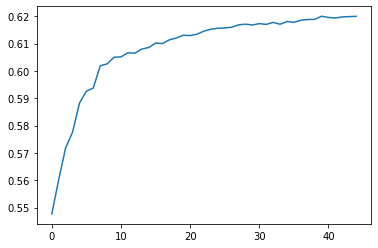

In [ ]:
score_array=[0.547688131785848,
0.5602396106327219,
0.5718410707600,
0.5775645825533509,
0.5881973043803819,
0.5925917259453388,
0.5937149007862222,
0.6018625982777985,
0.6025645825533508,
0.6049887682515911,
0.6051104455260202,
0.6066314114563834,
0.6064629352302509,
0.6079885810557843,
0.6085314488955448,
0.6101600524148258,
0.6099892390965543,
0.6113639528275816,
0.6120191362008904,
0.613042866862809,
0.6129141648519225,
0.6134348015128382,
0.6145462774714874,
0.6152541086730445,
0.615593407985698,
0.6157104055360805,
0.6159619432967587,
0.6168277326983345,
0.6170851233736958,
0.616780923411711,
0.6172840203215471,
0.6170032227784721,
0.617746155383992,
0.6170500118743706,
0.6180561998763758,
0.6177461529884823,
0.6185183455475071,
0.6187874389722937,
0.6188342355969371,
0.619986661596536,
0.6195420681673569,
0.619337325149136,
0.6197526620469672,
0.6198462621405674,
0.6199515613903284]

plt.plot(score_array)
plt.show()

### Regroupement des données 
On utilise ci dessous une fonction muette qui permet de retrouver les plus proches voisins associés à un actifs illiquides. L'idée étant de regrouper nos actifs liquides ensemble pour effectuer un traitement par lots.

In [ ]:
from sklearn.neighbors import KDTree

def selection_neigh_class(id_of_asset,number_of_neighbors):
    
    #Lecture des données supplémentaires
    supp_data=pd.read_csv("supplementary_data.csv",index_col=0)

    #On crée un arbre 
    tree = KDTree(supp_data, leaf_size=2)

    
    # On récupère la première ligne avec supp_data[:i]
    dist, ind = tree.query(supp_data[:id_of_asset], k=number_of_neighbors) 

    return ind

#Exemple avec l'actif numéroté 1, ses plus proches voisins sont les actifs 16 et 7, 0, 68 et 34
selection_neigh_class(1,5)


array([[ 0, 68,  7, 16, 34]])